© Steadforce GmbH 2020

#0. Get dependencies and the pretrained model

In [69]:
%%capture
!pip install shap
!pip install yolov5
!pip install scikit-image

# 1. Import stuff, load model and define utils

In [70]:
%matplotlib inline

import json
import random

import torch
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import cv2
import yolov5
import requests
from PIL import Image
import torchvision.transforms.functional as TF

from utils.general import non_max_suppression, box_iou

use_cuda = torch.cuda.is_available()

device = torch.device('gpu:0') if use_cuda is True else torch.device('cpu')

print(f'usging device: {device}')

usging device: cpu


In [71]:
model = yolov5.load('keremberke/yolov5m-license-plate', device=device).eval()
if use_cuda is True:
  _ = model.half() # use half precision float16 values

In [72]:
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

In [73]:
def download_img(url, path):
    with open(path, 'wb') as handle:
        response = requests.get(url, stream=True)
        for block in response.iter_content(1024):
            if not block:
                break

            handle.write(block)

def load_image_torch(path: str) -> np.ndarray:
    img = Image.open(path)
    img = TF.to_tensor(img).to(device).unsqueeze(0)
    return img


def preprocess_img(img: torch.Tensor, hw: int = 640, half: bool = True) -> torch.Tensor:
    img = torchvision.transforms.Resize((hw, hw))(img)
    if half is True:
        img = img.half()
    return img

def img_to_numpy(img: torch.Tensor) -> np.ndarray:
    return img.permute(1, 2, 0).numpy()

# 4. Implement adapter functions as NN layers

In [74]:
class CastNumpy(torch.nn.Module):
  def __init__(self, to: str, half: bool = False):
    super(CastNumpy, self).__init__()
    self.half = half
    self.to = to
    assert to in set(("numpy", "torch"))

  def forward(self, image):
    """
    In the forward function we accept the inputs and cast them to a pytorch tensor
    """

    image = np.ascontiguousarray(image)

    if self.to == "numpy":
        return image
    elif self.to == "torch":
        image = torch.from_numpy(image).to(device)

    if image.ndimension() == 3:
        image = image.unsqueeze(0)
    if self.half is True:
        return image.half()

    return image

numpy2torch_converter = CastNumpy(to="torch", half=torch.cuda.is_available())

In [75]:
class OD2Score(torch.nn.Module):
    """
    given target bbox, nms conf threshold, iou_threshold and predictions
    from model performes nms and reuturns score* base on prediction with
    best fitting bbox. If there are no predictions score is 0.

    bbox*, conf* - best fitting bbox and its score
    result = iou(target, bbox*) * conf*
    """

    def __init__(self, target_bbox: np.ndarray, conf_thresh: float = 0.01, iou_thresh: float = 0.5):
        super(OD2Score, self).__init__()
        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh
        self.target_bbox = torch.tensor(target_bbox, device=device)  # (1, 4) of (x1, y1, x2, y2)
        assert self.target_bbox.dim() == 2
        assert self.target_bbox.shape == (1, 4)


    def forward(self, prediction: torch.tensor):
        """
        In the forward function we accept the predictions and return the score for a selected target of the box
        prediction: (batch_size, n_detections, 6), where last dim has structure of (x1, y1, x2, y2, pred_score, pred_cls)

        (batch_size, n_detections, 6) -> (batch_size)
        """

        assert prediction.dim() == 3
        assert prediction.shape[2] == 6
        filtered = non_max_suppression(prediction, conf_thres=self.conf_thresh, iou_thres=self.iou_thresh) #  List of [tensor(n_detections, 6)] * batch_size

        scores = torch.zeros(len(filtered), device=prediction.device)

        for idx, batch in enumerate(filtered):
            # if there are no detections set score to 0
            if batch.shape[0] == 0:
                continue
            scores[idx] = (box_iou(self.target_bbox, batch[:, :4]) * batch[:, 4]).max()


        return scores

In [76]:
from skimage.util import img_as_float
from skimage.segmentation import slic, mark_boundaries


class SuperPixler(torch.nn.Module):
  def __init__(self, image, n_segments: int = 100, sigma: int = 0, compactness: float = 10.0):
    super(SuperPixler, self).__init__()

    self.image = image  # must be passed in float dtype scale [0, 1]
    assert image.shape[2] == 3
    self.mean_color = self.image.mean()
    self.mean_img = np.zeros_like(image) + self.mean_color
    self.segments = slic(image, n_segments=n_segments, sigma=sigma, compactness=compactness) - 1
    self.num_segments = self.segments.max().item() + 1


  def mark_boundaries(self):
      return mark_boundaries(self.image, self.segments)

  def get_segments(self):
      return self.segments.copy()

  def forward(self, masks: np.array):
    """
    In the forward step we accept the super pixel masks and transform them to a batch of images
    True - apply mask, False - do not apply mask
    """

    masks = masks.astype(bool)
    assert len(masks.shape) == 2
    assert masks.dtype == bool
    assert masks.shape[1] == self.num_segments

    # outputs are not stacking images
    n_outputs = masks.shape[0]
    outputs = np.stack(tuple(self.image.copy() for _ in range(n_outputs)), axis=0)

    for output_idx in range(n_outputs):
      for segment_idx in range(self.num_segments):
        if masks[output_idx][segment_idx].item() == True:
            # segments take value from [1, num_segments]
            m = (self.segments == segment_idx)
            outputs[output_idx][m] = self.mean_color

    # output is of shape (n_outputs, w, h, 3)
    return outputs


In [77]:
from typing import Tuple

class Permute(torch.nn.Module):
  def __init__(self, *permutation):
    super(Permute, self).__init__()
    self.permutation = tuple(permutation)

  def forward(self, x):
     return x.permute(self.permutation)


In [78]:
class BatchedProcessing(torch.nn.Module):
  def __init__(self, model: torch.nn.Module, batch_size: int = 64):
    super(BatchedProcessing, self).__init__()
    self.batch_size = batch_size
    self.model = model

  def _batch_division(self, n_elems: int, batch_size: int):
      last = 0
      curr = min(batch_size, n_elems)

      while curr <= n_elems:
          yield last, curr
          last = curr
          curr = curr + batch_size

      if last < n_elems:
          yield last, n_elems

  def forward(self, x: torch.Tensor):
      # assumes that first dim is batch size
      results = []
      total_elems = x.shape[0]

      for start, end in self._batch_division(total_elems, self.batch_size):
          r = self.model(x[start:end])
          results.append(r)

      return np.concatenate(results, axis=0)

In [79]:
def calculate_shap(super_pixler: SuperPixler, bbox_target: torch.Tensor, nsamples: int = 80, batch_size: int = 256) -> np.ndarray:
    background_super_pixel = np.ones((1, super_pixler.num_segments))
    image_super_pixel = np.zeros_like(background_super_pixel)

    patch_scorer = torch.nn.Sequential(
            super_pixler,  # (n_outputs, H, W, C) of float numpy
            CastNumpy(to="torch", half=torch.cuda.is_available()),  # (n_outputs, H, W, C) of float torch
            Permute(0, 3, 1, 2),  # (n_outputs, C, H, W) of float torch
            model,  # (n_outputs, num_detections, 6) of float torch
            OD2Score(bbox_target, model.conf, model.iou),  # (n_outputs, n_detections, 6) -> (n_outputs) of float torch,
            CastNumpy(to="numpy")  # (n_outputs, n_segments) of float numpy
    )

    batched_ps = BatchedProcessing(model=patch_scorer, batch_size=batch_size)  # (batch_size,) of numpy array,

    kernel_explainer = shap.KernelExplainer(batched_ps, background_super_pixel)
    shap_values = kernel_explainer.shap_values(image_super_pixel, nsamples=nsamples)
    return shap_values

In [80]:
from matplotlib.colors import Colormap
import matplotlib as mpl
import matplotlib.pylab as pl


def fill_segmentation(values, segmentation: np.ndarray):
    out = np.zeros_like(segmentation, dtype=float)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

def img_float_to_uint(img: np.ndarray):
    return (255 * img).astype(np.uint8)


def plot_shap_explenations(img: np.ndarray, shap_values: np.ndarray, segments: np.ndarray, blend_alpha: float = 0.5) -> np.ndarray:
    assert img.ndim == 3
    assert img.shape[2] == 3

    assert segments.ndim == 2
    assert segments.shape[0] == img.shape[0]
    assert segments.shape[1] == img.shape[1]

    assert shap_values.ndim == 1
    assert shap_values.shape[0] == segments.max() + 1

    absmax = np.abs(shap_values).max()

    cm = mpl.colormaps['seismic']
    norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-absmax, vmax=absmax)
    shap_val_mask = fill_segmentation(shap_values, segments)

    fig, ax = plt.subplots(ncols=1)
    ax.imshow(img_float_to_uint(img), alpha=1-blend_alpha)
    im = ax.imshow(shap_val_mask, cmap=cm, norm=norm, alpha=blend_alpha)
    ax.axis('off')
    cb = fig.colorbar(im, ax=ax, norm=norm, label="SHAP value", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)

    plt.show()


def plot_detections(img: np.ndarray, pred: torch.Tensor):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)

    img = (img * 255).astype(np.uint8).copy()
    d = [0, 1, 0, 1]
    for i in range(pred.shape[0]):
        x1, y1, x2, y2 = tuple(pred[i][:4].cpu().numpy().astype(int))
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(255,0,0), thickness=1)
    plt.imshow(img)

# 2. Do the actuall explaining
  - Load image
  - Check model prediction
  - Create reasonable segmentation
  - Calculate shap values for each segmentation patch
  - Create heatmap of patch influence

In [81]:
img_url = 'https://raw.githubusercontent.com/szysad/Licence-Plates-Det-Attacks/main/images/example.jpg'
download_img(img_url, 'plate1.png')
img = load_image_torch('plate1.png')
img = preprocess_img(img, half=use_cuda)[0]

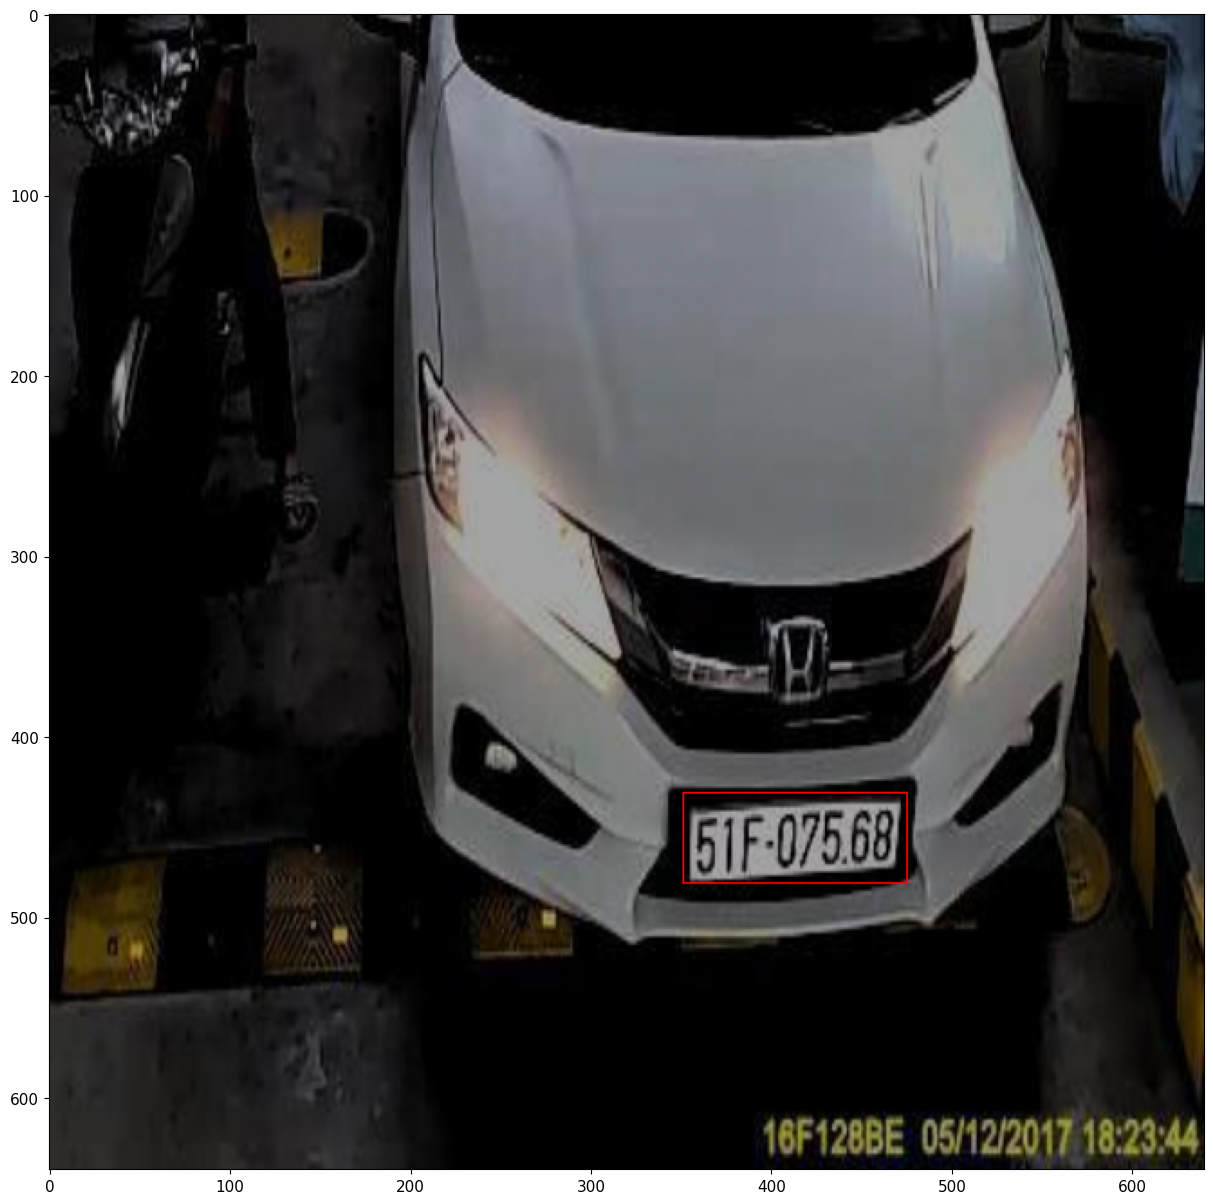

In [82]:
detections = model(img.unsqueeze(0))
detections = non_max_suppression(detections, conf_thres=model.conf, iou_thres=model.iou)
plot_detections(img_to_numpy(img), detections[0])

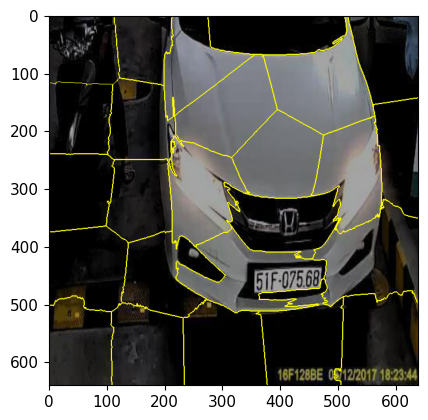

In [83]:
super_pixler = SuperPixler(img_to_numpy(img), n_segments=30, sigma=0, compactness=60)
plt.imshow(super_pixler.mark_boundaries())

In [85]:
target_bbox = detections[0][:, :4]
shap_v = calculate_shap(super_pixler, target_bbox, nsamples=250)

  0%|          | 0/1 [00:00<?, ?it/s]

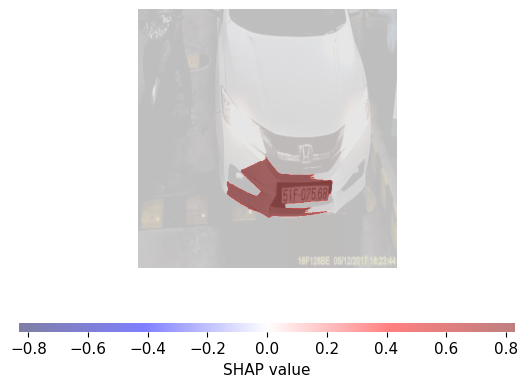

In [86]:
plot_shap_explenations(img_to_numpy(img), shap_v[0], super_pixler.get_segments(), 0.5)